In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [6]:
columns = ['sentiment', 'id', 'date', 'query', 'user', 'text']
df = pd.read_csv('training.1600000.processed.noemoticon.csv', 
                 encoding='latin-1', 
                 names=columns)

print("Dataset Boyutu:", df.shape)
print("\nİlk 5 satır:")
print(df.head())

print("\nSentiment Dağılımı:")
print(df['sentiment'].value_counts())

Dataset Boyutu: (1600000, 6)

İlk 5 satır:
   sentiment          id                          date     query  \
0          0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1          0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2          0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
3          0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4          0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   

              user                                               text  
0  _TheSpecialOne_  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1    scotthamilton  is upset that he can't update his Facebook by ...  
2         mattycus  @Kenichan I dived many times for the ball. Man...  
3          ElleCTF    my whole body feels itchy and like its on fire   
4           Karoli  @nationwideclass no, it's not behaving at all....  

Sentiment Dağılımı:
sentiment
0    800000
4    800000
Name: count, dtype: int64


In [7]:
df_sample=pd.concat([
    df[df["sentiment"]==0].sample(200000,random_state=42),
    df[df["sentiment"]==4].sample(200000,random_state=42)
]).sample(frac=1,random_state=42).reset_index(drop=True)

df_sample["sentiment"]=df_sample["sentiment"].map({0:0,4:1})
df_sample=df_sample[["text","sentiment"]]

print("Sample Dataset:")
print(df_sample.head(10))
print("\nYeni Sentiment Dağılımı:")
print(df_sample['sentiment'].value_counts())
print("\nÖrnek Pozitif Tweetler:")
print(df_sample[df_sample['sentiment'] == 1]['text'].head(3).values)
print("\nÖrnek Negatif Tweetler:")
print(df_sample[df_sample['sentiment'] == 0]['text'].head(3).values)


Sample Dataset:
                                                text  sentiment
0  would like to settle down and watch the footba...          0
1  reaalllly hungry. want pho. and/or fried chick...          0
2  @fiftypavements they don't air here so I have ...          0
3  is waiting for Kristin's call.... need to go o...          0
4  Susan Boyle(Bwaakk), Google Wave, BGT, Diversi...          1
5  @allsuffocation &lt;3 good choice. zomg that s...          0
6  What a deluge - now the grass is going to lap ...          1
7  just watched Lost s05 Finale: WOW! It will be ...          0
8  @mcflyharry kdkdkd vocÃª?  I'm missing you!!! ...          0
9  @rebeccamezzino lol!!! I think we are all guil...          1

Yeni Sentiment Dağılımı:
sentiment
0    200000
1    200000
Name: count, dtype: int64

Örnek Pozitif Tweetler:
['Susan Boyle(Bwaakk), Google Wave, BGT, Diversity, Lakers, Drag Me To Hell, LeBron, GoodNight, Winds, and Cavs. ) Follow me! '
 'What a deluge - now the grass is going 

In [8]:
stop_words = set(stopwords.words('english'))

def clean_text(text):
    # 1. Lowercase
    text = text.lower()
    
    # 2. Mention'ları temizle (@username)
    text = re.sub(r'@\w+', '', text)
    
    # 3. URL'leri temizle
    text = re.sub(r'http\S+|www\S+', '', text)
    
    # 4. Noktalama işaretlerini temizle (sadece harf ve boşluk kalsın)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # 5. Fazla boşlukları temizle
    text = re.sub(r'\s+', ' ', text).strip()

    #6. Stopwords ve kısa kelimeleri temizle
    tokens=text.split()
    tokens=[word for word in tokens if word not in stop_words and len(word)>2]

    return ' '.join(tokens)


print("ÖNCE vs SONRA Karşılaştırması:\n")
for i in range(5):
    original = df_sample.iloc[i]['text']
    cleaned = clean_text(original)
    sentiment = "POZİTİF" if df_sample.iloc[i]['sentiment'] == 1 else "NEGATİF"
    
    print(f"{sentiment}")
    print(f"ÖNCE:  {original}")
    print(f"SONRA: {cleaned}")
    print("-" * 80)

ÖNCE vs SONRA Karşılaştırması:

NEGATİF
ÖNCE:  would like to settle down and watch the football with a beer. Fat bloody chance of that. Too much to do. 
SONRA: would like settle watch football beer fat bloody chance much
--------------------------------------------------------------------------------
NEGATİF
ÖNCE:  reaalllly hungry. want pho. and/or fried chicken. and/or cici's pizza. damnit man 
SONRA: reaalllly hungry want pho andor fried chicken andor cicis pizza damnit man
--------------------------------------------------------------------------------
NEGATİF
ÖNCE:  @fiftypavements they don't air here so I have to watch them on YouTube 
SONRA: dont air watch youtube
--------------------------------------------------------------------------------
NEGATİF
ÖNCE:  is waiting for Kristin's call.... need to go out.. they're driving me nuts... 39... 39... 39 days left... still too long 
SONRA: waiting kristins call need theyre driving nuts days left still long
---------------------------

In [9]:
print("Veri Temizlemesi")

start_time = time.time()
df_sample["cleaned_text"] = df_sample["text"].apply(clean_text)
end_time = time.time()
print(f"Veri temizleme süresi: {end_time - start_time:.2f} saniye")

print(f"\n Boş tweet sayısı: {(df_sample['cleaned_text'] == '').sum()}")
df_sample = df_sample[df_sample['cleaned_text'] != ''].reset_index(drop=True)
print(f"\n Kalan tweet sayısı: {len(df_sample)}")

print("\n Temizlenmiş Veri Örneği:")
print(df_sample[['cleaned_text', 'sentiment']].head(10))

df_sample['word_count'] = df_sample['cleaned_text'].apply(lambda x: len(x.split()))
print("\n Kelime Sayısı İstatistikleri:")
print(df_sample['word_count'].describe())

Veri Temizlemesi
Veri temizleme süresi: 5.64 saniye

 Boş tweet sayısı: 2357

 Kalan tweet sayısı: 397643

 Temizlenmiş Veri Örneği:
                                        cleaned_text  sentiment
0  would like settle watch football beer fat bloo...          0
1  reaalllly hungry want pho andor fried chicken ...          0
2                             dont air watch youtube          0
3  waiting kristins call need theyre driving nuts...          0
4  susan boylebwaakk google wave bgt diversity la...          1
5  good choice zomg sounds awesome sadly tattoool...          0
6                  deluge grass going lap little lot          1
7  watched lost finale wow pretty hard wait find ...          0
8                       kdkdkd voc missing come back          0
9                               lol think guilty bec          1

 Kelime Sayısı İstatistikleri:
count    397643.000000
mean          6.754637
std           3.673492
min           1.000000
25%           4.000000
50%           6.

Pozitif Tweetlerde En Sık Geçen Kelimeler:


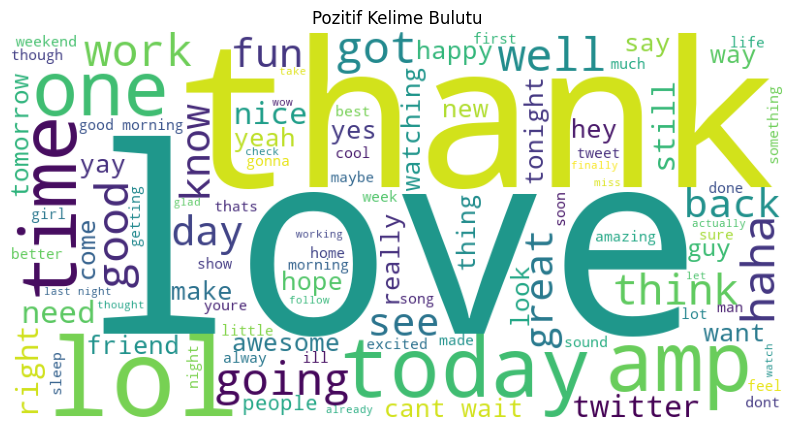

Negatif Tweetlerde En Sık Geçen Kelimeler:


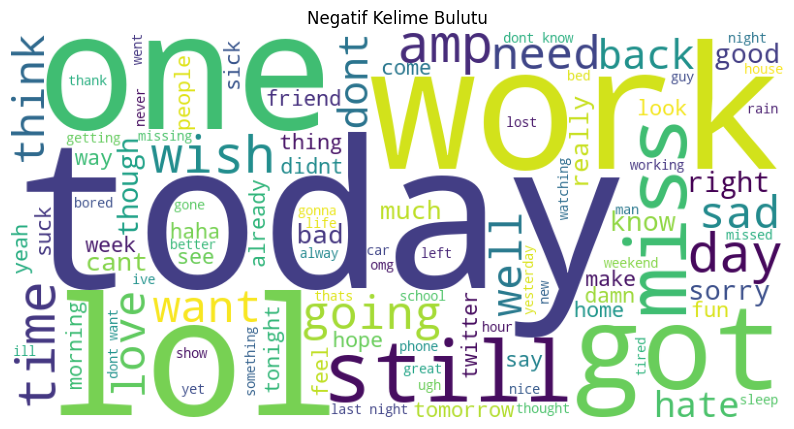

In [10]:
positive_text=" ".join(df_sample[df_sample['sentiment']==1]['cleaned_text'])
negative_text=" ".join(df_sample[df_sample["sentiment"]==0]["cleaned_text"])

def plot_wordcloud(text,title):
    wordcloud=WordCloud(width=800,height=400,random_state=21,max_words=100,background_color='white').generate(text)
    plt.figure(figsize=(10,7))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title(title)
    plt.show()

print("Pozitif Tweetlerde En Sık Geçen Kelimeler:")
plot_wordcloud(positive_text, "Pozitif Kelime Bulutu")

print("Negatif Tweetlerde En Sık Geçen Kelimeler:")
plot_wordcloud(negative_text, "Negatif Kelime Bulutu")

In [11]:
X=df_sample["cleaned_text"]
y=df_sample["sentiment"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,      
    random_state=42,    
    stratify=y          
)
print("Veri Bölünümü")
print(f"Training set: {len(X_train)} tweet")
print(f"Test set: {len(X_test)} tweet")
print(f"\n Training set sentiment dağılımı:")
print(y_train.value_counts())
print(f"\n Test set sentiment dağılımı:")
print(y_test.value_counts())

Veri Bölünümü
Training set: 318114 tweet
Test set: 79529 tweet

 Training set sentiment dağılımı:
sentiment
0    159149
1    158965
Name: count, dtype: int64

 Test set sentiment dağılımı:
sentiment
0    39788
1    39741
Name: count, dtype: int64


In [12]:
tfidf = TfidfVectorizer(
    max_features=15000,      
    ngram_range=(1, 3),     
    min_df=2,                
    max_df=0.95,             
    sublinear_tf=True,       
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    use_idf=True,
    smooth_idf=True
)

X_train_tfidf=tfidf.fit_transform(X_train)
X_test_tfidf=tfidf.transform(X_test)

print(f"Training: {X_train_tfidf.shape}")
print(f"Test: {X_test_tfidf.shape}")
print(f"\n Toplam kelime sayısı: {len(tfidf.get_feature_names_out())}")

feature_names = tfidf.get_feature_names_out()
print(f"\n İlk 20 kelime:")
print(feature_names[:20])
print(f"\n Son 20 kelime:")
print(feature_names[-20:])

Training: (318114, 15000)
Test: (79529, 15000)

 Toplam kelime sayısı: 15000

 İlk 20 kelime:
['aaa' 'aaaah' 'aaah' 'aaaw' 'aah' 'aahhh' 'aaron' 'aaww' 'abandoned'
 'abby' 'abc' 'ability' 'abit' 'able' 'able find' 'able get' 'able make'
 'able see' 'able sleep' 'able watch']

 Son 20 kelime:
['yung' 'yup' 'yur' 'zac' 'zach' 'zachary' 'zack' 'zealand' 'zero' 'zip'
 'zoe' 'zombie' 'zombies' 'zomg' 'zone' 'zones' 'zoo' 'zoom' 'zune' 'zzz']


In [13]:
lr_model = LogisticRegression(
    C=2.0,                   
    max_iter=1000,
    solver='liblinear',      
    random_state=42
)
lr_model.fit(X_train_tfidf, y_train)
lr_pred = lr_model.predict(X_test_tfidf)
lr_accuracy = accuracy_score(y_test, lr_pred)
print(f"Logistic Regression Accuracy: {lr_accuracy:.4f} ({lr_accuracy*100:.2f}%)\n")

nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)
nb_pred = nb_model.predict(X_test_tfidf)
nb_accuracy = accuracy_score(y_test, nb_pred)
print(f"Naive Bayes Accuracy: {nb_accuracy:.4f} ({nb_accuracy*100:.2f}%)\n")

rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_tfidf, y_train)
rf_pred = rf_model.predict(X_test_tfidf)
rf_accuracy = accuracy_score(y_test, rf_pred)
print(f"Random Forest Accuracy: {rf_accuracy:.4f} ({rf_accuracy*100:.2f}%)\n")


print("=" * 60)
print(" Modellerin Karşılaştırılması:")
print("=" * 60)
results = [
    ("Logistic Regression", lr_accuracy),
    ("Naive Bayes", nb_accuracy),
    ("Random Forest", rf_accuracy)
]

for model_name, acc in sorted(results, key=lambda x: x[1], reverse=True):
    print(f"{model_name:.<30} {acc*100:.2f}%")

print("\n En İyi Modelimiz:", max(results, key=lambda x: x[1])[0])

Logistic Regression Accuracy: 0.7801 (78.01%)

Naive Bayes Accuracy: 0.7645 (76.45%)

Random Forest Accuracy: 0.7641 (76.41%)

 Modellerin Karşılaştırılması:
Logistic Regression........... 78.01%
Naive Bayes................... 76.45%
Random Forest................. 76.41%

 En İyi Modelimiz: Logistic Regression


In [16]:
best_model=lr_model
best_pred=lr_pred
best_acc=lr_accuracy
print(classification_report(y_test, best_pred, 
                          target_names=['Negatif', 'Pozitif']))

              precision    recall  f1-score   support

     Negatif       0.79      0.76      0.78     39788
     Pozitif       0.77      0.80      0.78     39741

    accuracy                           0.78     79529
   macro avg       0.78      0.78      0.78     79529
weighted avg       0.78      0.78      0.78     79529



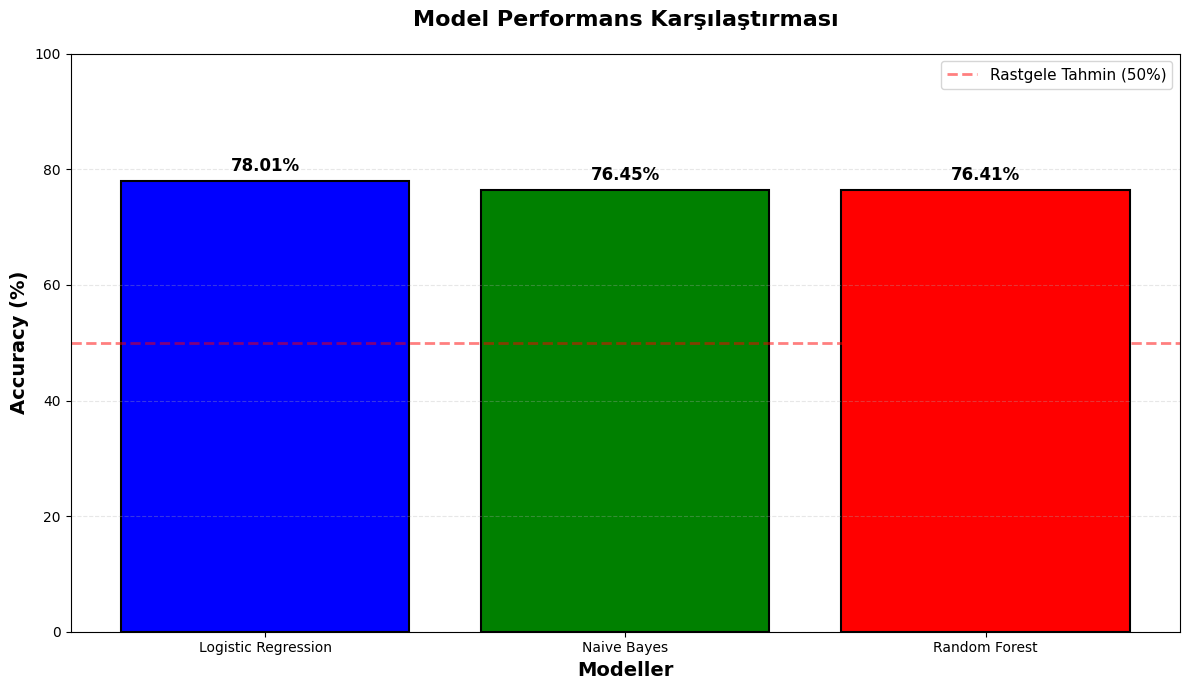

In [17]:
models = ["Logistic Regression", "Naive Bayes", "Random Forest"]
accuracies = [lr_accuracy*100, nb_accuracy*100, rf_accuracy*100]
colors = ["blue", "green", "red"]

plt.figure(figsize=(12,7))
bars = plt.bar(models, accuracies, color=colors, edgecolor="black", linewidth=1.5)

for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 1, 
             f'{acc:.2f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.axhline(y=50, color='red', linestyle='--', linewidth=2, alpha=0.5, 
            label='Rastgele Tahmin (50%)')
plt.ylim(0, 100)
plt.ylabel('Accuracy (%)', fontsize=14, fontweight='bold')
plt.xlabel('Modeller', fontsize=14, fontweight='bold')
plt.title('Model Performans Karşılaştırması', fontsize=16, fontweight='bold', pad=20)
plt.legend(fontsize=11)
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

In [18]:
def tahmin_et(text):
    cleaned = clean_text(text)
    
    vectorized = tfidf.transform([cleaned])
    
    prediction = best_model.predict(vectorized)[0]
    proba = best_model.predict_proba(vectorized)[0] 
    
    sentiment = "POZİTİF " if prediction == 1 else "NEGATİF "
    confidence = proba[prediction]
    print(f"Confidence: {confidence*100:.2f}%")
    
    print(f"Tweet: '{text}'")

    print(f"Modelin Gördüğü: '{cleaned}'") 
    print(f"Tahmin: {sentiment}")
    print("-" * 40)


# Pozitif
tahmin_et("I love this product, it is amazing and perfect!")

#Negatif
tahmin_et("This is the worst movie I have ever seen. Terrible acting.")

#Karışık
tahmin_et("I am so happy that I bought this.")
tahmin_et("My flight was delayed and my luggage is lost.")

Confidence: 99.14%
Tweet: 'I love this product, it is amazing and perfect!'
Modelin Gördüğü: 'love product amazing perfect'
Tahmin: POZİTİF 
----------------------------------------
Confidence: 93.15%
Tweet: 'This is the worst movie I have ever seen. Terrible acting.'
Modelin Gördüğü: 'worst movie ever seen terrible acting'
Tahmin: NEGATİF 
----------------------------------------
Confidence: 95.09%
Tweet: 'I am so happy that I bought this.'
Modelin Gördüğü: 'happy bought'
Tahmin: POZİTİF 
----------------------------------------
Confidence: 98.11%
Tweet: 'My flight was delayed and my luggage is lost.'
Modelin Gördüğü: 'flight delayed luggage lost'
Tahmin: NEGATİF 
----------------------------------------
